<a href="https://colab.research.google.com/github/GeraldL19/Final-Year-Project-PSDP/blob/main/w1827534_PSDP_Modelling_24_02_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Input

In [2]:
import pandas as pd
import numpy as np

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, f1_score , fbeta_score, precision_score

# Imbalance
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import RUSBoostClassifier

# Other
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Imputer
from sklearn.impute import KNNImputer

In [3]:
#Import clean dataset from GoogleDrive
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clean_data.csv", index_col=0)
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


# **Preprocessing**

In [4]:
# Encoding categorical variables
encoding_mapping = {
    'person_home_ownership': {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3},
    'loan_intent': {'PERSONAL': 0, 'EDUCATION': 1, 'MEDICAL': 2, 'VENTURE': 3, 'HOMEIMPROVEMENT': 4, 'DEBTCONSOLIDATION': 5},
    'loan_grade': {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6},
    'cb_person_default_on_file': {'Y': 0, 'N': 1}
}

for column, mapping in encoding_mapping.items():
    df[column] = df[column].replace(mapping)

# Split the dataset into X independent variables and y dependent variable (target)
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split the data into training and testing sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling numerical variables
cols_to_scale = ['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length']
scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


# Define KNNImputer
K_imputer = KNNImputer(n_neighbors=3, weights="uniform")
# Fit and Transform the dataset
X_train_imp = K_imputer.fit_transform(X_train)
X_test_imp = K_imputer.transform(X_test)

# Turn into dataframe
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns)

# **Spot Checking Algorithms**

In [4]:
# List of models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Tree': ExtraTreesClassifier(n_estimators=10, random_state=0),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier()
}

results_test_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC', 'Confusion Matrix'])

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    # Train the model
    model.fit(X_train_imp, y_train)
    # Make predictions
    y_pred = model.predict(X_test_imp)
    # Evaluate the model
    scores = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'F2 Score': fbeta_score(y_test, y_pred, beta=2),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test_imp)[:, 1]),
        'Confusion Matrix': confusion_matrix(y_test, y_pred)
    }

    results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)

# Highlight the best performers in the table
results_test_df_styled = results_test_df.style.highlight_max(axis=0, color='yellow', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC'])
results_test_df_styled

Training and evaluating Logistic Regression...


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)
<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Naive Bayes...
Training and evaluating Decision Tree...


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Random Forest...


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Extra Tree...


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating SVM...


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating XGBoost...


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Gradient Boosting...


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 4970, number of negative: 17716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 22686, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219078 -> initscore=-1.271048
[LightGBM] [Info] Start training from score -1.271048


<ipython-input-4-dd2a4a34b257>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_test_df = results_test_df.append({'Model': model_name, **scores}, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,Confusion Matrix
0,Logistic Regression,0.844801,0.725723,0.462229,0.564753,0.498422,0.847002,[[7235 370] [1139 979]]
1,Naive Bayes,0.806233,0.546950,0.643532,0.591323,0.621580,0.829133,[[6476 1129] [ 755 1363]]
2,Decision Tree,0.892111,0.744847,0.767705,0.756103,0.763022,0.847232,[[7048 557] [ 492 1626]]
3,Random Forest,0.931811,0.958412,0.718130,0.821053,0.756039,0.925121,[[7539 66] [ 597 1521]]
4,Extra Tree,0.914533,0.911708,0.672805,0.774246,0.710015,0.897721,[[7467 138] [ 693 1425]]
5,SVM,0.889129,0.866714,0.580264,0.695136,0.621335,0.869735,[[7416 189] [ 889 1229]]
6,XGBoost,0.935411,0.949337,0.743154,0.833686,0.776900,0.944406,[[7521 84] [ 544 1574]]
7,Gradient Boosting,0.926463,0.946531,0.702077,0.806181,0.740317,0.923717,[[7521 84] [ 631 1487]]
8,LightGBM,0.937262,0.975410,0.730406,0.835313,0.769040,0.944057,[[7566 39] [ 571 1547]]


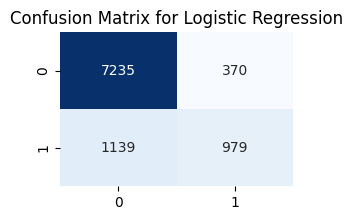

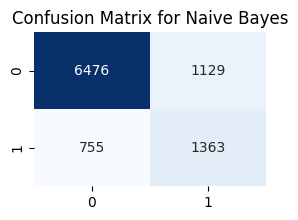

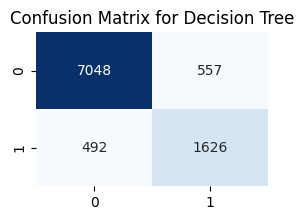

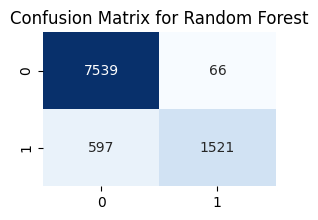

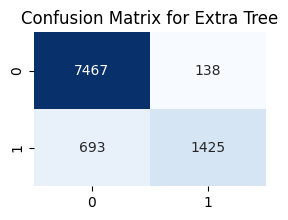

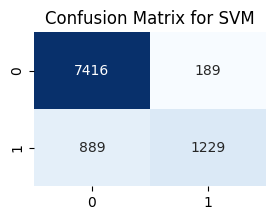

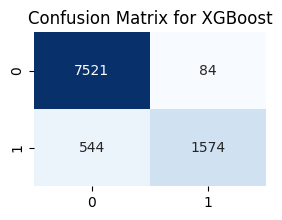

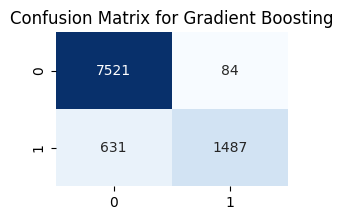

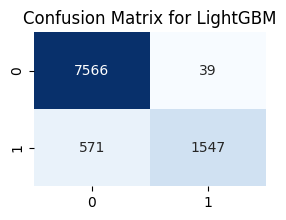

In [5]:
# Display the confusion matrix
for idx, row in results_test_df.iterrows():
    model_name = row['Model']
    confusion_mat = row['Confusion Matrix']

    plt.figure(figsize=(3, 2))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

*   XGBoost and LightGBM have the best overall accuracy.
*   Decision Tree has the best recall, which is important in our case as we aim to predict if an applicant is at risk of being rejected.

We decide to go ahead with these four algorithms for the next stage: DT, RF, XGBoost and LightGBM

# **Spot Checking Resampling methods**

The class imbalance needs to be addressed in order to lower the number of False Positive.

Multiple resampling methods will be tested, such as SMOTE, ADASYN, SMOTE + Tomek and SMOTE + ENN, to help mitigate the bias towards the majority class.

In [6]:
# List of models
models = {
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# SMOTE

In [7]:
# Applying SMOTE to the training set
X_train_smt, y_train_smt = SMOTE(random_state=42).fit_resample(X_train_imp, y_train)

results_smt = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC', 'Confusion Matrix'])

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    # Train the model
    model.fit(X_train_smt, y_train_smt)
    # Make predictions
    y_pred_smt = model.predict(X_test_imp)
    # Evaluate the model
    scores = {
        'Accuracy': accuracy_score(y_test, y_pred_smt),
        'Precision': precision_score(y_test, y_pred_smt),
        'Recall': recall_score(y_test, y_pred_smt),
        'F1 Score': f1_score(y_test, y_pred_smt),
        'F2 Score': fbeta_score(y_test, y_pred_smt, beta=2),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test_imp)[:, 1]),
        'Confusion Matrix': confusion_matrix(y_test, y_pred_smt)
    }

    results_smt = results_smt.append({'Model': model_name, **scores}, ignore_index=True)

# Highlight the best performers
results_smt_styled = results_smt.style.highlight_max(axis=0, color='yellow', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC'])
results_smt_styled

Training and evaluating Random Forest...


<ipython-input-7-87cf56bb42b4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smt = results_smt.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Decision Tree...


<ipython-input-7-87cf56bb42b4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smt = results_smt.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating XGBoost...


<ipython-input-7-87cf56bb42b4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smt = results_smt.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 17716, number of negative: 17716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 35432, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


<ipython-input-7-87cf56bb42b4>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smt = results_smt.append({'Model': model_name, **scores}, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,Confusion Matrix
0,Random Forest,0.924817,0.908181,0.728517,0.808488,0.758529,0.920925,[[7449 156] [ 575 1543]]
1,Decision Tree,0.866914,0.668163,0.772899,0.716725,0.749405,0.832998,[[6792 813] [ 481 1637]]
2,XGBoost,0.933457,0.938581,0.743154,0.829513,0.775446,0.942993,[[7502 103] [ 544 1574]]
3,LightGBM,0.936131,0.960615,0.737016,0.834090,0.773002,0.938975,[[7541 64] [ 557 1561]]


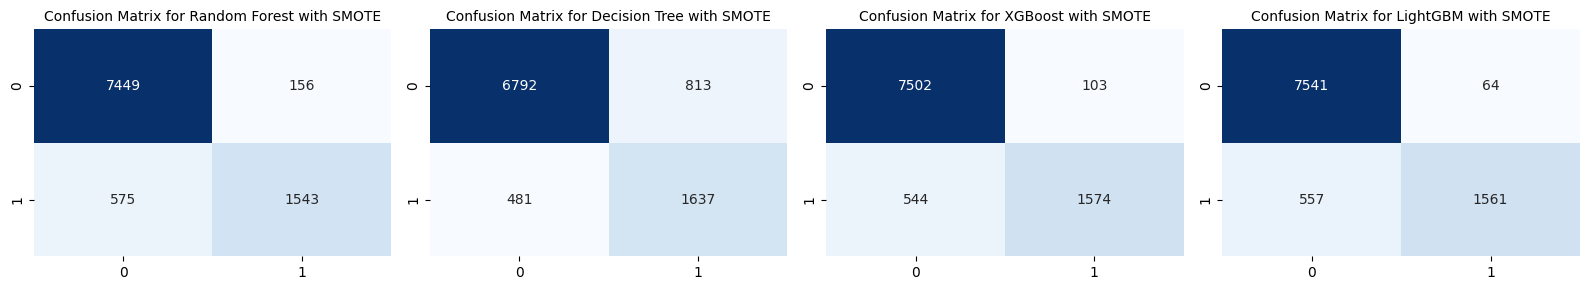

In [8]:
# Display confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for i, row in results_smt.iterrows():
    model_name = row['Model']
    confusion_mat = row['Confusion Matrix']
    ax = axes[i]
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name} with SMOTE', fontsize=10)

plt.tight_layout()

# ADASYN

In [9]:
# Applying ADASYN to the training set
X_train_ada, y_train_ada = ADASYN(random_state=42).fit_resample(X_train_imp, y_train)

results_ada = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC', 'Confusion Matrix'])

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    # Train the model
    model.fit(X_train_ada, y_train_ada)
    # Make predictions
    y_pred_ada = model.predict(X_test_imp)
    # Evaluate the model
    scores = {
        'Accuracy': accuracy_score(y_test, y_pred_ada),
        'Precision': precision_score(y_test, y_pred_ada),
        'Recall': recall_score(y_test, y_pred_ada),
        'F1 Score': f1_score(y_test, y_pred_ada),
        'F2 Score': fbeta_score(y_test, y_pred_ada, beta=2),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test_imp)[:, 1]),
        'Confusion Matrix': confusion_matrix(y_test, y_pred_ada)
    }

    results_ada = results_ada.append({'Model': model_name, **scores}, ignore_index=True)

# Highlight the best performers
results_ada_styled = results_ada.style.highlight_max(axis=0, color='yellow', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC'])
results_ada_styled

Training and evaluating Random Forest...


<ipython-input-9-8d27fe240339>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_ada = results_ada.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Decision Tree...


<ipython-input-9-8d27fe240339>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_ada = results_ada.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating XGBoost...


<ipython-input-9-8d27fe240339>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_ada = results_ada.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 17406, number of negative: 17716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2796
[LightGBM] [Info] Number of data points in the train set: 35122, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495587 -> initscore=-0.017653
[LightGBM] [Info] Start training from score -0.017653


<ipython-input-9-8d27fe240339>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_ada = results_ada.append({'Model': model_name, **scores}, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,Confusion Matrix
0,Random Forest,0.922555,0.891566,0.733711,0.804973,0.760646,0.920927,[[7416 189] [ 564 1554]]
1,Decision Tree,0.864239,0.661408,0.771955,0.712418,0.746985,0.830948,[[6768 837] [ 483 1635]]
2,XGBoost,0.932223,0.931402,0.743626,0.826989,0.774870,0.941798,[[7489 116] [ 543 1575]]
3,LightGBM,0.933971,0.952206,0.733711,0.828800,0.769002,0.938075,[[7527 78] [ 564 1554]]


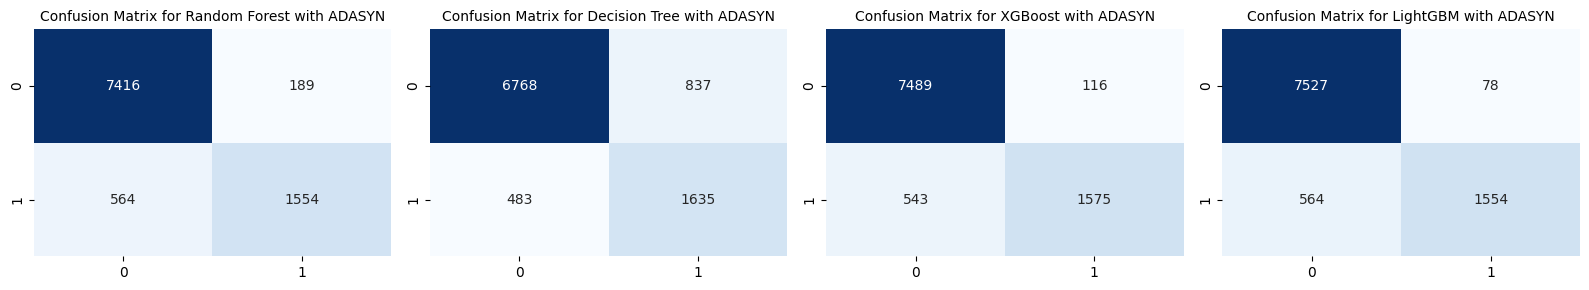

In [10]:
# Display confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for i, row in results_ada.iterrows():
    model_name = row['Model']
    confusion_mat = row['Confusion Matrix']
    ax = axes[i]
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name} with ADASYN', fontsize=10)

plt.tight_layout()

# SMOTE and Tomek

In [11]:
# Applying SMOTETomek to the training set
X_train_smtek, y_train_smtek = SMOTETomek(random_state=42).fit_resample(X_train_imp, y_train)

results_smtek = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC', 'Confusion Matrix'])

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    # Train the model
    model.fit(X_train_smtek, y_train_smtek)
    # Make predictions
    y_pred_smt = model.predict(X_test_imp)
    # Evaluate the model
    scores = {
        'Accuracy': accuracy_score(y_test, y_pred_smt),
        'Precision': precision_score(y_test, y_pred_smt),
        'Recall': recall_score(y_test, y_pred_smt),
        'F1 Score': f1_score(y_test, y_pred_smt),
        'F2 Score': fbeta_score(y_test, y_pred_smt, beta=2),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test_imp)[:, 1]),
        'Confusion Matrix': confusion_matrix(y_test, y_pred_smt)
    }

    results_smtek = results_smtek.append({'Model': model_name, **scores}, ignore_index=True)

# Highlight the best performers
results_smtek_styled = results_smtek.style.highlight_max(axis=0, color='yellow', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC'])
results_smtek_styled

Training and evaluating Random Forest...


<ipython-input-11-857ff82cd050>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smtek = results_smtek.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Decision Tree...


<ipython-input-11-857ff82cd050>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smtek = results_smtek.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating XGBoost...


<ipython-input-11-857ff82cd050>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smtek = results_smtek.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 17531, number of negative: 17531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 35062, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


<ipython-input-11-857ff82cd050>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smtek = results_smtek.append({'Model': model_name, **scores}, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,Confusion Matrix
0,Random Forest,0.925435,0.906597,0.733239,0.810754,0.762396,0.920114,[[7445 160] [ 565 1553]]
1,Decision Tree,0.872467,0.681255,0.779037,0.726872,0.757298,0.838762,[[6833 772] [ 468 1650]]
2,XGBoost,0.933148,0.937426,0.742682,0.828767,0.774877,0.938540,[[7500 105] [ 545 1573]]
3,LightGBM,0.933971,0.952761,0.733239,0.828709,0.768660,0.937713,[[7528 77] [ 565 1553]]


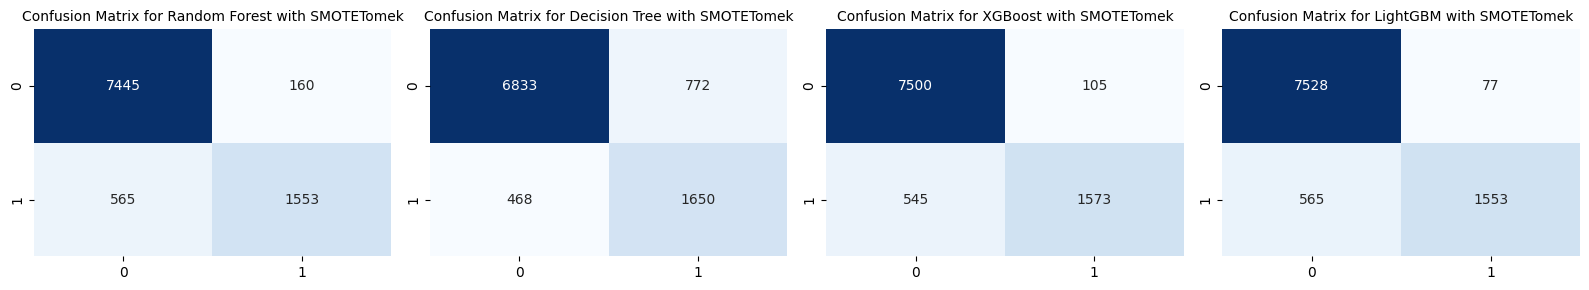

In [12]:
# Display confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for i, row in results_smtek.iterrows():
    model_name = row['Model']
    confusion_mat = row['Confusion Matrix']
    ax = axes[i]
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name} with SMOTETomek', fontsize=10)

plt.tight_layout()

# SMOTE + ENN Algorithm

In [13]:
# Applying SMOTEENN to the training set
X_train_smenn, y_train_smenn = SMOTEENN(random_state=42).fit_resample(X_train_imp, y_train)

results_smenn = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC', 'Confusion Matrix'])

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    # Train the model
    model.fit(X_train_smenn, y_train_smenn)
    # Make predictions
    y_pred_smenn = model.predict(X_test_imp)
    # Evaluate the model
    scores = {
        'Accuracy': accuracy_score(y_test, y_pred_smenn),
        'Precision': precision_score(y_test, y_pred_smenn),
        'Recall': recall_score(y_test, y_pred_smenn),
        'F1 Score': f1_score(y_test, y_pred_smenn),
        'F2 Score': fbeta_score(y_test, y_pred_smenn, beta=2),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test_imp)[:, 1]),
        'Confusion Matrix': confusion_matrix(y_test, y_pred_smenn)
    }

    results_smenn = results_smenn.append({'Model': model_name, **scores}, ignore_index=True)

# Highlight the best performers
results_smenn_styled = results_smenn.style.highlight_max(axis=0, color='yellow', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score', 'AUC'])
results_smenn_styled

Training and evaluating Random Forest...


<ipython-input-13-185d5bad76e5>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smenn = results_smenn.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating Decision Tree...


<ipython-input-13-185d5bad76e5>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smenn = results_smenn.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating XGBoost...


<ipython-input-13-185d5bad76e5>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smenn = results_smenn.append({'Model': model_name, **scores}, ignore_index=True)


Training and evaluating LightGBM...
[LightGBM] [Info] Number of positive: 15800, number of negative: 12623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 28423, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555888 -> initscore=0.224489
[LightGBM] [Info] Start training from score 0.224489


<ipython-input-13-185d5bad76e5>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_smenn = results_smenn.append({'Model': model_name, **scores}, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,Confusion Matrix
0,Random Forest,0.887278,0.729766,0.766289,0.747582,0.758695,0.913516,[[7004 601] [ 495 1623]]
1,Decision Tree,0.851383,0.625419,0.792257,0.699021,0.752129,0.830053,[[6600 1005] [ 440 1678]]
2,XGBoost,0.908773,0.803053,0.770066,0.786214,0.776445,0.929852,[[7205 400] [ 487 1631]]
3,LightGBM,0.908362,0.804769,0.764873,0.784314,0.772532,0.926779,[[7212 393] [ 498 1620]]


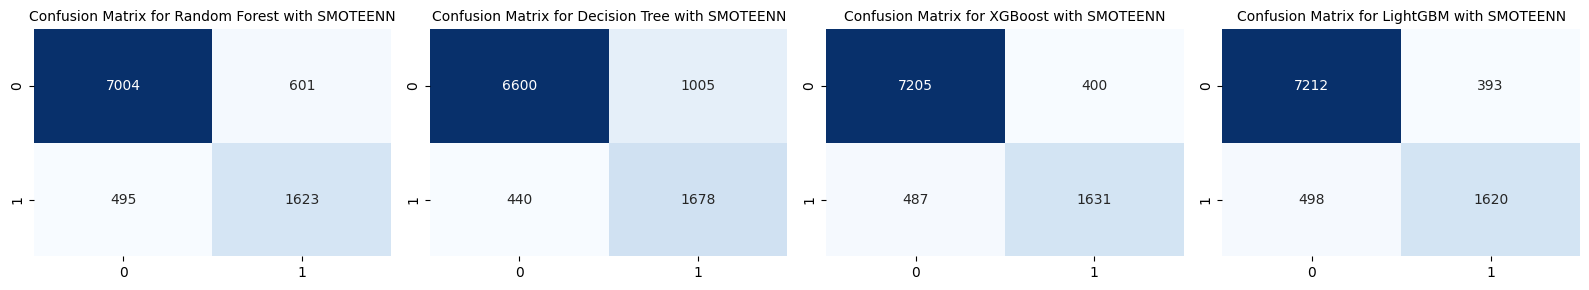

In [14]:
# Display confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16, 3))

for i, row in results_smenn.iterrows():
    model_name = row['Model']
    confusion_mat = row['Confusion Matrix']
    ax = axes[i]
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name} with SMOTEENN', fontsize=10)

plt.tight_layout()

# **HyperParameter Tuning**

We take the best overall performing model and resampling method  (XGBoost + SMOTEENN) and use a randomiser to find the best parameters for the model.

# RandomSearch for SMOTEEN and XGBOOST

Accuracy: 0.9086701635297748
Precision: 0.8038537549407114
Recall : 0.7681775259678942
F1 Score : 0.785610816030903
F2 Score : 0.7750571646341463
ROC AUC Score: 0.9265247814822886

Confusion Matrix:
[[7208  397]
 [ 491 1627]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7605
           1       0.80      0.77      0.79      2118

    accuracy                           0.91      9723
   macro avg       0.87      0.86      0.86      9723
weighted avg       0.91      0.91      0.91      9723



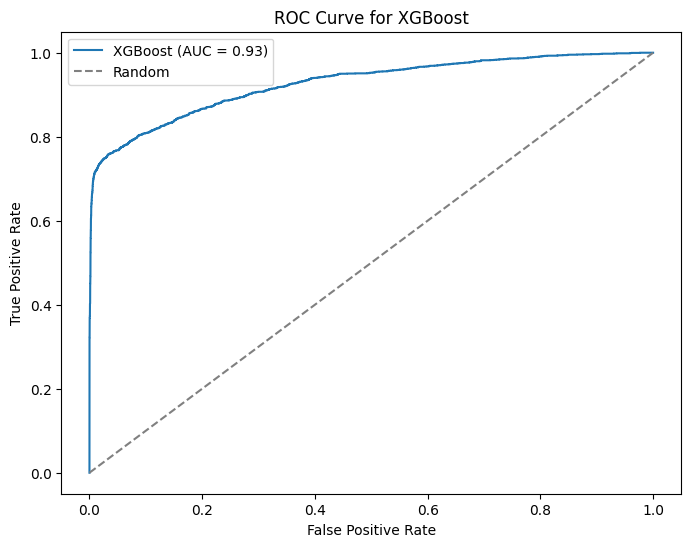

In [5]:
# Applying SMOTEENN to the training set
X_train_sme, y_train_sme = SMOTEENN(random_state=42).fit_resample(X_train_imp, y_train)

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.1, 0.5, 1, 10],
    'reg_lambda': [0, 0.1, 0.5, 1, 10]
}

# Create an XGBoost classifier
xgb_classifier = XGBClassifier()
# Create StratifiedKFold cross-validator
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# Create RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='recall', cv=cv)
# Fit the model
random_search.fit(X_train_sme, y_train_sme)
# Get the best model
best_xgb = random_search.best_estimator_
# Make predictions
y_pred_smt = best_xgb.predict(X_test_imp)

# Evaluate the model
accuracy_smt = accuracy_score(y_test, y_pred_smt)
precision_smt = precision_score(y_test, y_pred_smt)
recall_smt = recall_score(y_test, y_pred_smt)
f1_smt = f1_score(y_test, y_pred_smt)
f2_smt = fbeta_score(y_test, y_pred_smt, beta=2)
conf_matrix_smt = confusion_matrix(y_test, y_pred_smt)
roc_auc_xgb = roc_auc_score(y_test, best_xgb.predict_proba(X_test_imp)[:, 1])

print(f'Accuracy: {accuracy_smt}')
print(f'Precision: {precision_smt}')
print(f'Recall : {recall_smt}')
print(f'F1 Score : {f1_smt}')
print(f'F2 Score : {f2_smt}')
print(f'ROC AUC Score: {roc_auc_xgb}\n')
print(f'Confusion Matrix:\n{conf_matrix_smt}\n')

print("Classification Report:")
print(classification_report(y_test, y_pred_smt))

# Plot ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test_imp)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion Matrix for best model (XGBoost with SMOTEENN)')

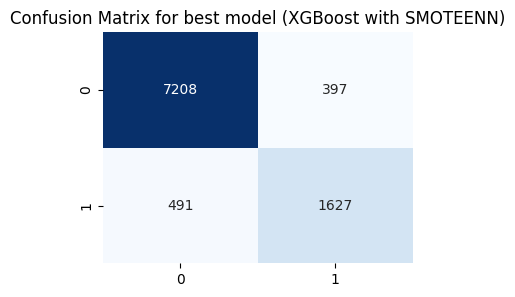

In [13]:
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_smt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f'Confusion Matrix for best model (XGBoost with SMOTEENN)', fontsize=12)

In [18]:
# Get best model parameter
random_search.best_params_

{'subsample': 0.7,
 'reg_lambda': 0.5,
 'reg_alpha': 1,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 11,
 'learning_rate': 0.2,
 'gamma': 0.5,
 'colsample_bytree': 0.7}

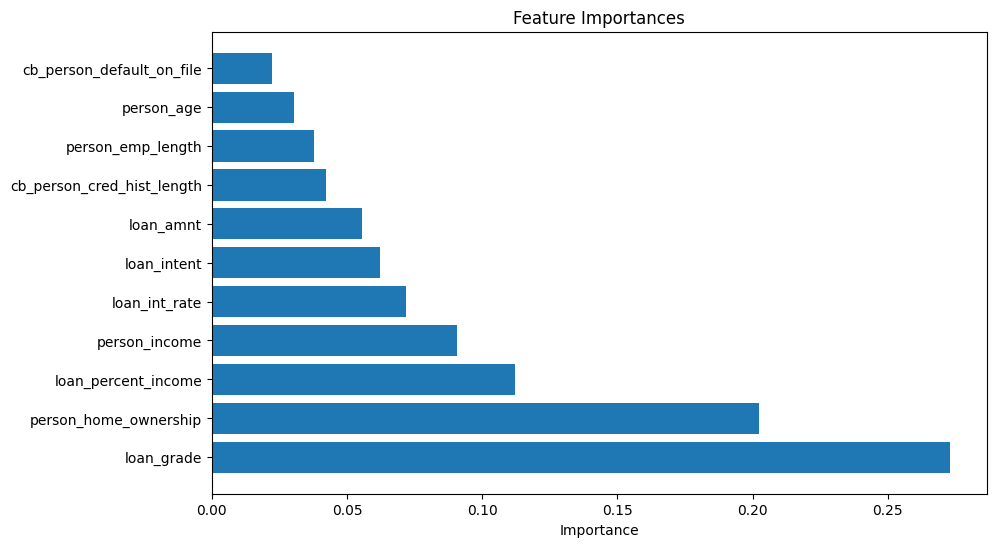

In [19]:
# Get feature importances
importances = best_xgb.feature_importances_

# Create a DataFrame to organize feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()